# Forecasting Bitcoin price with a RNN (LSTM)

explanation on LSTM: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [73]:
train_size, test_size, start = 305,15,3800 # window on which we fit and test our model #758 50 2265

n_input = 20 # window used by the model to forecast the next step

data = pd.read_csv('data/bitcoin.csv', index_col=0)

data.iloc[start:start+train_size]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-09-24,1240.000000,1246.739990,1210.680054,1218.760010,1583200,0,0.0
2019-09-25,1215.819946,1248.300049,1210.089966,1246.520020,1453000,0,0.0
2019-09-26,1241.959961,1245.000000,1232.267944,1241.390015,1538000,0,0.0
2019-09-27,1243.010010,1244.020020,1214.449951,1225.089966,1353900,0,0.0
2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1404100,0,0.0
...,...,...,...,...,...,...,...
2020-12-01,1774.369995,1824.829956,1769.369995,1798.099976,1736900,0,0.0
2020-12-02,1798.099976,1835.650024,1789.473022,1827.949951,1222000,0,0.0
2020-12-03,1824.010010,1847.199951,1822.650024,1826.770020,1227300,0,0.0


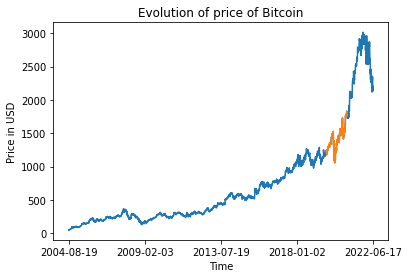

In [74]:
price = data['Close']

plt.plot(price)
plt.plot(price.iloc[start:start+train_size])
plt.title('Evolution of price of Bitcoin')
plt.ylabel('Price in USD')
plt.xlabel('Time')

plt.xticks([price.index[i*(len(price)-1)//4]for i in range(5)])

plt.show()

In [75]:
log_price = price.map(np.log)

log_ret = pd.DataFrame({'log_ret': np.diff(log_price, 1)}, index=log_price.index[1:])

scaler = MinMaxScaler()

log_ret_rescale = scaler.fit_transform(log_ret)

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


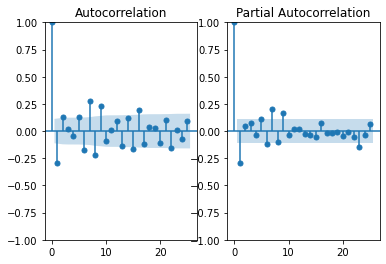

In [76]:
# plotting acf and pacf

fig, axs = plt.subplots(nrows=1, ncols=2)

sm.graphics.tsa.plot_acf(log_ret_rescale[start:start+train_size], ax=axs[0])
sm.graphics.tsa.plot_pacf(log_ret_rescale[start:start+train_size], ax=axs[1])

plt.show()

In [77]:
generator = TimeseriesGenerator(
    data=log_ret_rescale[start:start+train_size],
    targets=log_ret_rescale[start:start+train_size],
    length=n_input,
    batch_size=4
    )

In [78]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(n_input, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128)               66560     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [79]:
hist = model.fit(generator, epochs=10000)

Epoch 1/10000
72/72 [==============================] - 2s 8ms/step - loss: 0.0116
Epoch 2/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 3/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 4/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 5/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 6/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0060
Epoch 7/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0061
Epoch 8/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0060
Epoch 9/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0059
Epoch 10/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0059
Epoch 11/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 12/10000
72/72 [==============================] - 1s 8ms/step - loss: 0.0057
Epoch 13/1000

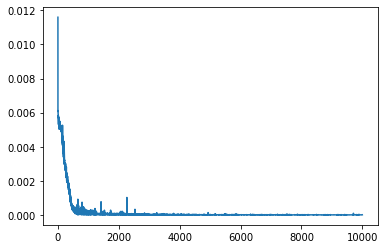

In [80]:
loss_per_epoch = model.history.history['loss']

plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [81]:
preds = []

for i in range(test_size):

    batch = log_ret_rescale[start+train_size-n_input+i:start+train_size+i].reshape((1, n_input, 1))
    preds.append(model.predict(batch))

preds = np.array(preds)

1/1 [==============================] - 0s 15ms/step


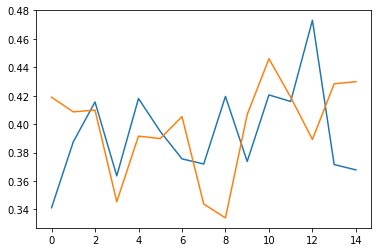

In [82]:
plt.plot(range(test_size), log_ret_rescale[start+train_size:start+train_size+test_size])
plt.plot(range(test_size), preds[:, 0, 0])

plt.show()

In [83]:
MSE = np.mean([(preds[i, 0, 0]- log_ret_rescale[start+train_size+i])**2 for i in range(test_size)])

MSE

0.0021590234653631035